### Persp Research
#### Joseph Denby

Load relevant packages and functions. 

In [19]:
lucem_illud.setupStanfordNLP()

Starting downloads, this will take 5-10 minutes
../stanford-NLP/parser already exists, skipping download
../stanford-NLP/ner already exists, skipping download
../stanford-NLP/postagger already exists, skipping download
../stanford-NLP/core already exists, skipping download
[100%]Done setting up the Stanford NLP collection


In [21]:
import pandas as pd
import numpy as np
import random
import math
import statistics

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy
from scipy import stats
import lucem_illud
import lucem_illud.stanford as stanford

import nltk
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
%matplotlib inline

/Users/josephdenby/anaconda/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/Users/josephdenby/anaconda/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


In [48]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)

In [49]:
def wordsample(tokens, n):
    '''
    takes a list of tokens (or sentences) and an amount (n) and returns a random sample
    
    Inputs:
        tokens - list of tokenized text
        n - int
    
    Outputs:
        sample - contiguous n sample from tokens
    '''
    
    if len(tokens) <= n:
        sample = tokens
    else:
        startindex = random.randint(1, len(tokens)-n)
        sample = tokens[startindex : startindex+n]
    
    return sample

In [50]:
def POSdict(tokens_POS):
    '''
    takes a list of tuples indicating POS taggings for tokenized words and returns 
    a dictionary counting up the POS tag instances
    
    Inputs:
        tokens_POS - list of tuples
        
    Outputs:
        POSdict - dictionary
    '''
    POSdict = {}
    for t in tokens_POS:
        word, tag = t
        if tag not in ['.', ',', "''", '#', '?', '!', ':', '(', ')', '$', '"', '``']:
            if tag not in POSdict:
                POSdict[tag] = 0
            POSdict[tag] += 1
    
    return POSdict

In [51]:
def getavgPOSdict(POSdictseries):
    '''
    takes a series of POSdicts and returns a dictionary with the average POS counts 
    
    Inputs:
        POSdictseries - series of POSdicts
        
    Outputs:
        avgPOSdict - dictionary
    '''
    
    avgPOSdict = {}
    total = len(POSdictseries)
    
    for d in POSdictseries:
        for k, v in d.items():
            if k not in avgPOSdict:
                avgPOSdict[k] = 0
            avgPOSdict[k] += v/total
    
    return avgPOSdict
    

In [52]:
def averageSampleCounts(dataframe, n):
    '''
    Takes a DataFrame and returns a dictionary
    with the counts for each POS found in a random contiguous n word sample.
    
    Inputs:
        dataframe - DataFrame
    
    Outputs:
        avgPOSdict - dictionary 
    
    '''
    tag = str(n) + 'wordsample'
    
    dataframe[tag] = dataframe['tokens'].apply(lambda x: wordsample(x, n))
    dataframe['tokens_POS'] = [nltk.pos_tag(t) for t in dataframe[tag]]
    
    dataframe['POSdict'] = dataframe['tokens_POS'].apply(lambda x: POSdict(x))
    avgPOSdict = getavgPOSdict(dataframe['POSdict'])
    
    return avgPOSdict
    
    

In [53]:
def getPOSdf(chatavgavgPOSdict, bookavgavgPOSdict):
    '''
    Takes two dictionaries with the average average POS counts and converts them into a single melted DataFrame,
    primed for plotting.
    
    Inputs:
        chatavgavgPOSdict - dictionary
        bookavgavgPOSdict - dictionary
    Output:
        compareavgPOSdf - DataFrame
    '''
    
    chatavgPOSdf = pd.DataFrame.from_dict(chatavgavgPOSdict, orient = 'index')
    bookavgPOSdf = pd.DataFrame.from_dict(bookavgavgPOSdict, orient = 'index')
    
    chatavgPOSdf = chatavgPOSdf.reset_index()
    bookavgPOSdf = bookavgPOSdf.reset_index()
    
    chatavgPOSdf = chatavgPOSdf.rename(columns = {'index': 'POS', 0: 'speech'})
    bookavgPOSdf = bookavgPOSdf.rename(columns = {'index': 'POS', 0: 'book'})
    
    compareavgPOSdf = bookavgPOSdf.merge(chatavgPOSdf, how='left', on='POS',)
    compareavgPOSdf['abs_diff'] = compareavgPOSdf.apply(lambda x: x['book'] - x['speech'], axis=1)
    compareavgPOSdf['factor_diff'] = compareavgPOSdf.apply(lambda x: (x['book']-x['speech'])/x['book'], axis=1)
    compareavgPOSdf = compareavgPOSdf.sort_values('factor_diff', ascending=False)
    compareavgPOSdf = compareavgPOSdf.reset_index(drop=True)
    compareavgPOSdf = compareavgPOSdf.melt(id_vars=['POS'], value_vars=['book', 'speech'], var_name='source', value_name='avgcount')
    
    return compareavgPOSdf

In [54]:
def getPOSsterrs(avgPOSdicts):
    POSsterrs = {}
    for d in avgPOSdicts:
        for k, v in d.items():
            if k not in POSsterrs:
                POSsterrs[k] = []
            POSsterrs[k].append(v)
                    
    for k, v in POSsterrs.items():
        POSsterrs[k] = np.array(v)
        POSsterrs[k] = np.std(v)/np.sqrt(len(POSsterrs[k]))
    return POSsterrs

In [55]:
def makePOScountsdf(POSdicts):
    '''
    Takes list/series of POS dictionaries and creates a dataframe with the counts for each POS tag.
    '''
    POSdicts = POSdicts.tolist()
    firstdic = POSdicts.pop()
    POScountsdf = pd.DataFrame.from_dict(firstdic,orient='index')
    
    for d in POSdicts:
        initdf = pd.DataFrame.from_dict(d,orient='index')
        POScountsdf = POScountsdf.merge(initdf, how='left', left_index=True, right_index=True)
    
    return POScountsdf

In [56]:
def avgwordsample(tokens, wordn, samplen):
    '''
    Takes a list of tokens and returns an dictionary of POS counts for a wordn random sample conducted samplen times.
    
    Outputs:
        avgPOSdict 
    '''
    sampledictlist = []
    
    for _ in range(samplen):
        sample = wordsample(tokens, wordn)
        samplePOS = nltk.pos_tag(sample)
        sampledict = POSdict(samplePOS)
        sampledictlist.append(sampledict)
    
    avgPOSdict = getavgPOSdict(sampledictlist)
    
    return avgPOSdict

In [57]:
def sent_complexity(sents):
    '''
    Takes a list of lists (sentences) with tokenized words and returns a list of each sentence's depth 
    when represented as a parsed tree
    
    Inputs:
        sents (list of lists)
    Outputs:
        sentheights (list)
    '''

    parses = list(stanford.parser.parse_sents(sents))
    sentheights = []
    for s in parses:
        sentheights.append(list(s)[0].height())
    
    return sentheights

In [58]:
def avg_sent_complexity(sents, sentn, samplen):
    '''
    Takes a list of sentences with tokenized words, takes a sample of those sentences with size sentn, and,
    on that sample, compute each sentence's depth when represented as a parse tree. Repeats this process samplen
    times and returns an average average parse tree depth.
    
    Inputs:
        sents (list of lists)
        sentn (int)
        samplen (int)
    Outputs:
        allavg_sentheights (list)
        allsd_sentheights (list)
    '''
    allavg_sentheights = []
    allsd_sentheights = []
    
    for _ in range(samplen):
        sample = wordsample(sents, sentn)
        sentheights = sent_complexity(sample)
        avg_sentheights = np.mean(sentheights)
        sd_sentheights = np.std(sentheights)
        allavg_sentheights.append(avg_sentheights)
        allsd_sentheights.append(sd_sentheights)
    
    return allavg_sentheights, allsd_sentheights
        
        

TODO
- Organize by difference between counts. __[DONE]__
- Look at change over time (based on session or suggested grade/age level for books) __[DONE]__
- look at distribution of speech (variability, not just means) and plot alongside books __[DONE]__
- Try parsing - look at tree depth over book sentences. (*some measure of complexity*) __[DONE]__
- ANOVA for comparing differences (filter out variance due to individual differences)
- kids POS productions/sentence complexity over time
- compare with adult conversation corpus (Santa Barbara?) and adult book text
- Lexile measure for books? __[Not great]__
- Examine differences in trajectory for chat by SES __[DONE]__
- Investigate word specificity / concreteness with WordNet
- Oxford Children's Corpus (look at writing *by* children)

Read in dataframes:

### Parent & Child CHAT DATAFRAMES

In [59]:
utterances = pd.read_csv('utterances.csv', index_col=0)
utterances.rename(columns={'session':'age'}, inplace=True)
utterances.fillna(value = {'p_chat':'', 'c_chat':''}, inplace=True)

/Users/josephdenby/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [60]:
utterances['p_chat'] = utterances['p_chat'].apply(lambda x: x + ' ')
utterances['c_chat'] = utterances['c_chat'].apply(lambda x: x + ' ')

In [61]:
p_chats = utterances.groupby(['subject', 'age'])['p_chat'].sum().reset_index()
#c_chats = utterances.groupby(['subject', 'age'])['c_chat'].sum().reset_index()

In [62]:
p_chats['sents'] = p_chats['p_chat'].apply(lambda x: nltk.sent_tokenize(x))
p_chats['sent_tokens'] = p_chats['sents'].apply(lambda v: [nltk.wordpunct_tokenize(s) for s in v])

In [63]:
#c_chats['sents'] = c_chats['c_chat'].apply(lambda x: nltk.sent_tokenize(x))
#c_chats['sent_tokens'] = c_chats['sents'].apply(lambda v: [nltk.wordpunct_tokenize(s) for s in v])

Clean out sessions where parents/children talk very little (too small samples):

In [64]:
lowsentcounts = []
for i, s in enumerate(p_chats['sents']):
    if len(s) < 50 or not s:
        lowsentcounts.append(i)
for i in lowsentcounts:
    p_chats.drop(i, inplace=True)
p_chats.reset_index(inplace=True, drop=True)

In [65]:
# lowsentcounts = []
# for i, s in enumerate(c_chats['sents']):
#     if len(s) < 10 or not s:
#         lowsentcounts.append(i)
# for i in lowsentcounts:
#     c_chats.drop(i, inplace=True)
# c_chats.reset_index(inplace=True, drop=True)

In [66]:
p_chats['tokens'] = p_chats.p_chat.apply(lambda x: nltk.wordpunct_tokenize(x))
p_chats['word_count'] = p_chats.tokens.apply(lambda x: len(x))

In [67]:
p_chats.head()

,subject,age,p_chat,sents,sent_tokens,tokens,word_count
0,22,1,"play with Mommy's hand . no . no, no, no . nop...","[play with Mommy's hand ., no ., no, no, no .,...","[[play, with, Mommy, ', s, hand, .], [no, .], ...","[play, with, Mommy, ', s, hand, ., no, ., no, ...",4702
1,22,2,what are you crawling for ? stand up . what ...,"[ what are you crawling for ?, stand up ., wh...","[[what, are, you, crawling, for, ?], [stand, u...","[what, are, you, crawling, for, ?, stand, up, ...",5798
2,22,3,you want to show her how you do a head+stand ?...,[you want to show her how you do a head+stand ...,"[[you, want, to, show, her, how, you, do, a, h...","[you, want, to, show, her, how, you, do, a, he...",5477
3,22,4,how do flowers taste ? yeah . do you eat flow...,"[how do flowers taste ?, yeah ., do you eat fl...","[[how, do, flowers, taste, ?], [yeah, .], [do,...","[how, do, flowers, taste, ?, yeah, ., do, you,...",8349
4,22,5,what ? you brought it down because you said...,"[ what ?, you brought it down because you said...","[[what, ?], [you, brought, it, down, because, ...","[what, ?, you, brought, it, down, because, you...",6904


#### Import Subject SES data (by income)

In [68]:
subj_income = pd.read_csv('subj_incomes.csv', index_col=0, na_values=0)
subj_income.reset_index(inplace=True, drop=True)
subj_income = subj_income[subj_income.session<=12]

In [69]:
subj_income.income = subj_income.groupby('subject').income.transform(lambda x: x.mean())
subj_income.dropna(inplace=True)
subj_income.income = subj_income.income.round()
subj_income.rename(columns={'session':'age'}, inplace=True)

In [70]:
p_chats = p_chats.merge(subj_income, how ='left', on=['subject','age'])
p_chats.dropna(inplace=True)
p_chats.reset_index(inplace=True, drop=True)
p_chats.income = p_chats.income.apply(lambda x: int(x))

In [71]:
p_chats['lowSES'] = p_chats.income.apply(lambda x: x<=3) #any income below $50,000 is lowSES

In [72]:
p_chats.lowSES.value_counts()/(p_chats.shape[0])

False    0.695011
True     0.304989
Name: lowSES, dtype: float64

In [73]:
p_chats.income.value_counts()/(p_chats.shape[0])

6    0.274376
4    0.227891
5    0.192744
2    0.154195
3    0.099773
1    0.051020
Name: income, dtype: float64

### BOOK DATAFRAME

In [74]:
bookdf = pd.read_csv("bookdf.csv", index_col=0)

## 
bookdf = bookdf.drop(15) #to get rid of 'Goodnight Moon' which has less than 100 words
bookdf = bookdf.drop(74) #drop 'Chicka Chicka 1-2-3' because the parser has trouble with it (numbers?)
bookdf = bookdf.reset_index(drop=True)
##

bookdf['tokens'] = bookdf['text'].apply(lambda x: nltk.wordpunct_tokenize(x))
bookdf['sents'] = bookdf['text'].apply(lambda x: nltk.sent_tokenize(x))
bookdf['sent_tokens'] = bookdf['sents'].apply(lambda v: [nltk.wordpunct_tokenize(s) for s in v])
bookdf['word_count'] = bookdf.tokens.apply(lambda x: len(x))


In [75]:
bookdf

,author,text,title,tokens,sents,sent_tokens,word_count
0,Jules Feiffer,"George’s mother said: ""Bark, George."" George w...","Bark, George","[George, ’, s, mother, said, :, "", Bark, ,, Ge...","[George’s mother said: ""Bark, George."", George...","[[George, ’, s, mother, said, :, "", Bark, ,, G...",364
1,Robert McCloskey,"One day, Little Sal went with her mother to Bl...",Blueberries for Sal,"[One, day, ,, Little, Sal, went, with, her, mo...","[One day, Little Sal went with her mother to B...","[[One, day, ,, Little, Sal, went, with, her, m...",1253
2,Bill Martin Jr,"Brown Bear, Brown Bear, What do you see? I see...","Brown Bear, Brown Bear, What Do You See?","[Brown, Bear, ,, Brown, Bear, ,, What, do, you...","[Brown Bear, Brown Bear, What do you see?, I s...","[[Brown, Bear, ,, Brown, Bear, ,, What, do, yo...",251
3,Doreen Cronin,Farmer Brown has a problem. His cows like to t...,"Click, Clack, Moo Cows that Type","[Farmer, Brown, has, a, problem, ., His, cows,...","[Farmer Brown has a problem., His cows like to...","[[Farmer, Brown, has, a, problem, .], [His, co...",541
4,Judi Barrett,We were all sitting around the big kitchen tab...,Cloudy With a Chance of Meatballs,"[We, were, all, sitting, around, the, big, kit...",[We were all sitting around the big kitchen ta...,"[[We, were, all, sitting, around, the, big, ki...",1423
5,Don Freeman,Corduroy is a bear who once lived in the toy d...,Corduroy,"[Corduroy, is, a, bear, who, once, lived, in, ...",[Corduroy is a bear who once lived in the toy ...,"[[Corduroy, is, a, bear, who, once, lived, in,...",824
6,H.A. Rey,This is George. He lived in Africa. He was a g...,Curious George,"[This, is, George, ., He, lived, in, Africa, ....","[This is George., He lived in Africa., He was ...","[[This, is, George, .], [He, lived, in, Africa...",1136
7,Sheila McGraw,A mother held her new baby and very slowly roc...,Love You Forever,"[A, mother, held, her, new, baby, and, very, s...",[A mother held her new baby and very slowly ro...,"[[A, mother, held, her, new, baby, and, very, ...",956
8,Ruth Krauss,A little boy planted a carrot seed. His mother...,The Carrot Seed,"[A, little, boy, planted, a, carrot, seed, ., ...","[A little boy planted a carrot seed., His moth...","[[A, little, boy, planted, a, carrot, seed, .]...",128
9,Ezra Jack Keats,One winter morning Peter woke up and looked ou...,The snowy Day,"[One, winter, morning, Peter, woke, up, and, l...",[One winter morning Peter woke up and looked o...,"[[One, winter, morning, Peter, woke, up, and, ...",382


### No Words Books

In [33]:
nowordsbooks = pd.read_csv('booknotext.csv',index_col=0)

In [37]:
nowordsbooks['tokens'] = nowordsbooks['utt'].apply(lambda x: nltk.wordpunct_tokenize(x))

In [38]:
nowordsbooks.head()

,start,end,utt,subj,tokens
0,9.533530,12.382162,that is the gorilla do you see the moon in the...,1,"[that, is, the, gorilla, do, you, see, the, mo..."
1,13.762199,15.434851,very good,1,"[very, good]"
2,16.683678,19.483336,no moon,1,"[no, moon]"
3,19.989397,22.682946,look the gorilla is taking his keys,1,"[look, the, gorilla, is, taking, his, keys]"
4,23.613445,27.678255,you know what those are for mom and dad use ke...,1,"[you, know, what, those, are, for, mom, and, d..."


### Procedure for Computing TTR

#### NO WORDS BOOKS

In [39]:
nwbooktext = nowordsbooks.tokens.sum()

In [43]:
len(nwbooktext)

1536

In [44]:
nwbooktext_ttrs = []
for i in range(100,len(nwbooktext),100):
    for j in range(100):
        samp = wordsample(nwbooktext, i)
        tokens = len(samp)
        types = len(set(samp))
        nwbooktext_ttrs.append((types,tokens, 'NWBook'))

#### CHAT

##### Low SES

In [76]:
lowSESchat = p_chats[p_chats.lowSES].tokens.sum()

In [77]:
lowSESchat_ttrs = []
for i in range(100,30000,100):
    for j in range(100):
        samp = wordsample(lowSESchat, i)
        tokens = len(samp)
        types = len(set(samp))
        lowSESchat_ttrs.append((types,tokens, 'Low SES'))

##### High SES

In [78]:
highSESchat = p_chats[p_chats.lowSES==False].tokens.sum()

In [79]:
highSESchat_ttrs = []
for i in range(100,30000,100):
    for j in range(100):
        samp = wordsample(highSESchat, i)
        tokens = len(samp)
        types = len(set(samp))
        highSESchat_ttrs.append((types,tokens, 'High SES'))

##### All speech

In [ ]:
#allchat = p_chats.tokens.sum()

In [183]:
# chat_ttrs = []
# for i in range(100,30000,100):
#     for j in range(100):
#         samp = wordsample(allchat, i)
#         tokens = len(samp)
#         types = len(set(samp))
#         chat_ttrs.append((types,tokens, 'chat'))

#### BOOKS

In [80]:
allbooks = bookdf.tokens.sum()

In [81]:
book_ttrs = []
for i in range(100,30000,100):
    for j in range(100):
        samp = wordsample(allbooks, i)
        tokens = len(samp)
        types = len(set(samp))
        book_ttrs.append((types,tokens, 'Book'))

In [82]:
all_chat_ttrs = lowSESchat_ttrs + highSESchat_ttrs
all_books_ttrs = book_ttrs + nwbooktext_ttrs
all_ttrs = all_chat_ttrs + all_books_ttrs
#all_ttrs = chat_ttrs + book_ttrs

In [84]:
ttrs_df = pd.DataFrame(all_ttrs)
ttrs_df.columns = ['types','tokens','source']

In [85]:
meanttrs = ttrs_df.groupby(['source','tokens']).mean()
meanttrs.reset_index(inplace=True)

In [148]:
meanttrs = pd.read_csv('meanttrs.csv', index_col=0)

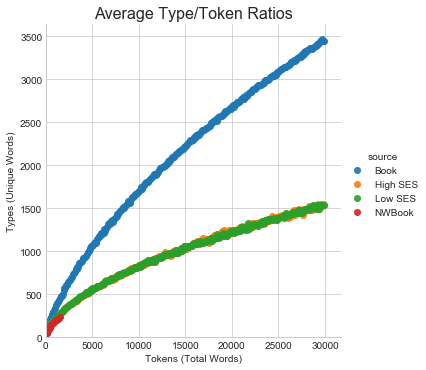

In [87]:
sns.set_style('whitegrid')
g = sns.lmplot(x = 'tokens',y='types', data = meanttrs, fit_reg=False, hue='source',scatter_kws={'alpha':0.9})
axes = g.axes.flatten()
axes[0].set_title('Average Type/Token Ratios', fontsize=16);
axes[0].set_xlabel('Tokens (Total Words)');
axes[0].set_ylabel('Types (Unique Words)');
axes[0].set_ylim(0,);
axes[0].set_xlim(0,);
#g.savefig('ttrs.png', dpi=200 ,bbox_inches = 'tight')

### Procedure for Computing and Plotting Sentence Complexities

In [23]:
#VERY SLOW (>1hr)
#p_chats['sent_complexities'] = p_chats['sent_tokens'].apply(lambda x: sent_complexity(wordsample(x, 90)))
#p_chats['avg_sent_complex'] = p_chats['sent_complexities'].apply(lambda x: np.mean(x))
#p_chats['sd_sent_complex'] = p_chats['sent_complexities'].apply(lambda x: np.std(x))

In [158]:
p_complex_df = pd.read_csv('p_complexity_data.csv', index_col=0)
p_complex_df.rename(columns={'session':'age'}, inplace=True)
#p_complex_df['age'] = p_complex_df['session'].apply(lambda x: (x-1)*4+14)
p_complex_df['book'] = False
p_complex_df = p_complex_df.merge(p_chats, how ='left', on=['subject','age'])

In [161]:
p_complex_df['source'] = p_complex_df.lowSES.apply(lambda x: 'Low SES' if x else 'High SES')

In [163]:
p_complex_df.head()

,subject,age,sent_complexities,avg_sent_complex,sd_sent_complex,book,p_chat,sents,sent_tokens,tokens,word_count,income,lowSES,source
0,22,1,"[5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 8, 5, ...",6.677778,1.942666,False,"play with Mommy's hand . no . no, no, no . nop...","[play with Mommy's hand ., no ., no, no, no .,...","[[play, with, Mommy, ', s, hand, .], [no, .], ...","[play, with, Mommy, ', s, hand, ., no, ., no, ...",4702.0,5.0,False,High SES
1,22,2,"[7, 6, 6, 5, 6, 6, 5, 6, 4, 4, 6, 10, 5, 5, 10...",6.322222,1.678808,False,what are you crawling for ? stand up . what ...,"[ what are you crawling for ?, stand up ., wh...","[[what, are, you, crawling, for, ?], [stand, u...","[what, are, you, crawling, for, ?, stand, up, ...",5798.0,5.0,False,High SES
2,22,3,"[5, 11, 5, 5, 7, 11, 5, 4, 6, 6, 7, 5, 11, 6, ...",6.688889,2.009115,False,you want to show her how you do a head+stand ?...,[you want to show her how you do a head+stand ...,"[[you, want, to, show, her, how, you, do, a, h...","[you, want, to, show, her, how, you, do, a, he...",5477.0,5.0,False,High SES
3,22,4,"[5, 9, 4, 8, 6, 4, 6, 9, 11, 6, 5, 7, 4, 7, 11...",6.433333,1.751507,False,how do flowers taste ? yeah . do you eat flow...,"[how do flowers taste ?, yeah ., do you eat fl...","[[how, do, flowers, taste, ?], [yeah, .], [do,...","[how, do, flowers, taste, ?, yeah, ., do, you,...",8349.0,5.0,False,High SES
4,22,5,"[5, 6, 6, 6, 5, 6, 12, 9, 6, 5, 5, 8, 5, 5, 8,...",7.400000,2.462158,False,what ? you brought it down because you said...,"[ what ?, you brought it down because you said...","[[what, ?], [you, brought, it, down, because, ...","[what, ?, you, brought, it, down, because, you...",6904.0,5.0,False,High SES


In [35]:
#VERY SLOW (~1hr)
#bookdf['sent_complexity'] = bookdf['sent_tokens'].apply(lambda x: sent_complexity(x))
#bookdf['avg_sent_complex'] = bookdf['sent_complexity'].apply(lambda x: np.mean(x))
#bookdf['stdev_sent_complex'] = bookdf['sent_complexity'].apply(lambda x: np.std(x))

In [165]:
book_complex_df = pd.read_csv('book_complexity_data.csv', index_col=0)
book_complex_df['book'] = True
book_complex_df['age'] = 'book'
book_complex_df['source'] = 'book'
book_complex_df.rename(columns={'sent_complexity':'sent_complexities','stdev_sent_complex':'sd_sent_complex'},inplace=True)

In [166]:
book_complex_df.head()

,author,title,sent_complexities,avg_sent_complex,sd_sent_complex,book,age,source
0,Jules Feiffer,"Bark, George","[11, 7, 9, 6, 6, 5, 9, 9, 8, 5, 7, 9, 6, 6, 5,...",6.500000,2.299068,True,book,book
1,Robert McCloskey,Blueberries for Sal,"[9, 10, 8, 10, 8, 4, 4, 6, 7, 8, 5, 9, 11, 9, ...",9.950617,3.295718,True,book,book
2,Bill Martin Jr,"Brown Bear, Brown Bear, What Do You See?","[11, 9, 11, 9, 11, 9, 11, 9, 11, 9, 11, 9, 11,...",9.739130,1.187522,True,book,book
3,Doreen Cronin,"Click, Clack, Moo Cows that Type","[6, 7, 7, 5, 5, 9, 5, 5, 5, 5, 5, 9, 8, 8, 14,...",6.761905,1.831941,True,book,book
4,Judi Barrett,Cloudy With a Chance of Meatballs,"[8, 6, 6, 9, 14, 7, 10, 4, 4, 7, 11, 6, 7, 12,...",8.756757,2.835477,True,book,book


In [168]:
complex_df = p_complex_df.drop(columns=['subject','p_chat','sents','sent_tokens','tokens','word_count','income','lowSES']).append(book_complex_df.drop(columns=['author','title']))
complex_df.reset_index(inplace=True, drop=True)

In [170]:
complex_df.head()

,age,avg_sent_complex,book,sd_sent_complex,sent_complexities,source
0,1,6.677778,False,1.942666,"[5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 8, 5, ...",High SES
1,2,6.322222,False,1.678808,"[7, 6, 6, 5, 6, 6, 5, 6, 4, 4, 6, 10, 5, 5, 10...",High SES
2,3,6.688889,False,2.009115,"[5, 11, 5, 5, 7, 11, 5, 4, 6, 6, 7, 5, 11, 6, ...",High SES
3,4,6.433333,False,1.751507,"[5, 9, 4, 8, 6, 4, 6, 9, 11, 6, 5, 7, 4, 7, 11...",High SES
4,5,7.400000,False,2.462158,"[5, 6, 6, 6, 5, 6, 12, 9, 6, 5, 5, 8, 5, 5, 8,...",High SES


In [28]:
regplot_df = complex_df[complex_df['age']!='book']
regplot_df['age'] = regplot_df['age'].apply(lambda x: int(x))

/Users/josephdenby/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


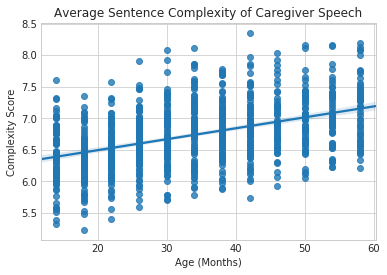

In [58]:
g = sns.regplot(x = 'age', y = 'avg_sent_complex', data = regplot_df)
g.set_title('Average Sentence Complexity of Caregiver Speech');
g.set_xlabel('Age (Months)');
g.set_ylabel('Complexity Score');
#plt.savefig('p_complex.png',bbox_inches='tight')

/home/jgdenby/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


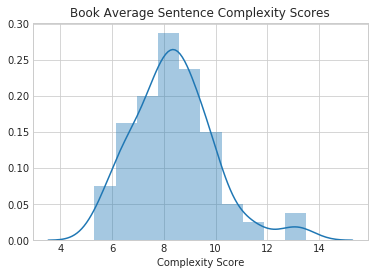

In [59]:
g = sns.distplot(complex_df[complex_df['age']=='book']['avg_sent_complex'])
g.set_title('Book Average Sentence Complexity Scores');
g.set_xlabel('Complexity Score');
#plt.savefig('bookscoresdist.png', bbox_inches = 'tight')

In [182]:
complex_df = pd.read_csv('complexitydf.csv', index_col=0)

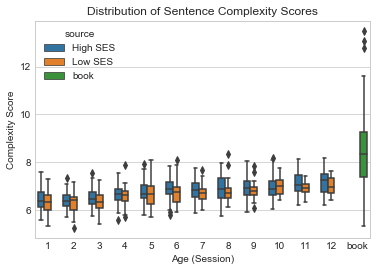

In [184]:
sns.set_style('whitegrid')
g = sns.boxplot(x='age', y = 'avg_sent_complex', hue = 'source', data=complex_df)
#g.legend_.remove()
g.set_title('Distribution of Sentence Complexity Scores');
g.set_xlabel('Age (Session)')
g = g.set_ylabel('Complexity Score')
plt.savefig('p&b_complex.png',dpi=200,bbox_inches = 'tight')

### Procedure for Computing and Plotting Average 150 Word POS Counts

#### For Speech

In [27]:
#set word sample size
n = 150

In [29]:
#SLOW (~10mins) - creates a dictionary for each conversation of the POS count for the average n word sample
p_chats['avg150wordPOScount'] = p_chats['tokens'].apply(lambda x:avgwordsample(x, n, 50))

In [32]:
p_chats

,subject,age,p_chat,sents,sent_tokens,tokens,word_count,income,lowSES,avg150wordPOScount
0,22,1,"play with Mommy's hand . no . no, no, no . nop...","[play with Mommy's hand ., no ., no, no, no .,...","[[play, with, Mommy, ', s, hand, .], [no, .], ...","[play, with, Mommy, ', s, hand, ., no, ., no, ...",4702,5,False,"{'JJ': 6.040000000000001, 'VBP': 6.54000000000..."
1,22,2,what are you crawling for ? stand up . what ...,"[ what are you crawling for ?, stand up ., wh...","[[what, are, you, crawling, for, ?], [stand, u...","[what, are, you, crawling, for, ?, stand, up, ...",5798,5,False,"{'DT': 7.579999999999997, 'NN': 15.32000000000..."
2,22,3,you want to show her how you do a head+stand ?...,[you want to show her how you do a head+stand ...,"[[you, want, to, show, her, how, you, do, a, h...","[you, want, to, show, her, how, you, do, a, he...",5477,5,False,"{'JJ': 4.100000000000001, 'NNP': 4.10000000000..."
3,22,4,how do flowers taste ? yeah . do you eat flow...,"[how do flowers taste ?, yeah ., do you eat fl...","[[how, do, flowers, taste, ?], [yeah, .], [do,...","[how, do, flowers, taste, ?, yeah, ., do, you,...",8349,5,False,"{'PRP': 18.180000000000003, 'VB': 10.379999999..."
4,22,5,what ? you brought it down because you said...,"[ what ?, you brought it down because you said...","[[what, ?], [you, brought, it, down, because, ...","[what, ?, you, brought, it, down, because, you...",6904,5,False,"{'NN': 18.880000000000006, 'JJ': 6.52, 'IN': 8..."
5,22,6,do do do . &xxx get the foot book ? where is ...,"[ do do do ., &xxx get the foot book ?, where ...","[[do, do, do, .], [&, xxx, get, the, foot, boo...","[do, do, do, ., &, xxx, get, the, foot, book, ...",7141,5,False,"{'PRP': 13.74, 'VBP': 6.979999999999998, 'JJ':..."
6,22,7,right ? are you a mysterious girl ? no on...,"[ right ?, are you a mysterious girl ?, no on...","[[right, ?], [are, you, a, mysterious, girl, ?...","[right, ?, are, you, a, mysterious, girl, ?, n...",5125,5,False,"{'NN': 18.46, 'WRB': 1.2000000000000004, 'PRP'..."
7,22,8,"no, I'm not going all the way up . who's the...","[ no, I'm not going all the way up ., who's th...","[[no, ,, I, ', m, not, going, all, the, way, u...","[no, ,, I, ', m, not, going, all, the, way, up...",5432,5,False,"{'WDT': 0.38000000000000006, 'VBP': 6.14, 'DT'..."
8,22,9,it is a bride's veil . can we get married ? b...,"[it is a bride's veil ., can we get married ?,...","[[it, is, a, bride, ', s, veil, .], [can, we, ...","[it, is, a, bride, ', s, veil, ., can, we, get...",7067,5,False,"{'NNS': 3.7200000000000015, 'NN': 16.680000000..."
9,22,10,what are you guys doing ? you guys want...,"[ what are you guys doing ?, you guys want...","[[what, are, you, guys, doing, ?], [you, guys,...","[what, are, you, guys, doing, ?, you, guys, wa...",6034,5,False,"{'NNS': 3.060000000000002, 'RB': 7.41999999999..."


In [52]:
sessionPOSdicts = p_chats.groupby(['age','lowSES']).avg150wordPOScount.apply(list)
sessionPOSdicts = sessionPOSdicts.to_frame()
sessionPOSdicts.reset_index(inplace=True)
#sessionPOSdicts['age'] = sessionPOSdicts['age'].apply(lambda x: 4*x +10)

#collapses sessions across people
sessionPOSdicts['avgPOS'] = sessionPOSdicts['avg150wordPOScount'].apply(lambda x: getavgPOSdict(x))

In [53]:
sessionPOSdicts

,age,lowSES,avg150wordPOScount,avgPOS
0,1,False,"[{'JJ': 6.040000000000001, 'VBP': 6.5400000000...","{'JJ': 6.9271698113207565, 'VBP': 5.7637735849..."
1,1,True,"[{'MD': 2.080000000000001, 'VB': 15.5599999999...","{'MD': 1.1508333333333336, 'VB': 11.9458333333..."
2,2,False,"[{'DT': 7.579999999999997, 'NN': 15.3200000000...","{'DT': 8.658214285714282, 'NN': 19.68178571428..."
3,2,True,"[{'NNP': 6.600000000000001, 'DT': 9.32, 'PRP':...","{'NNP': 5.180833333333335, 'DT': 8.44249999999..."
4,3,False,"[{'JJ': 4.100000000000001, 'NNP': 4.1000000000...","{'JJ': 6.6213559322033895, 'NNP': 4.1538983050..."
5,3,True,"[{'PRP': 14.620000000000005, 'NN': 20.66000000...","{'PRP': 13.750833333333336, 'NN': 20.379166666..."
6,4,False,"[{'PRP': 18.180000000000003, 'VB': 10.37999999...","{'PRP': 14.427419354838715, 'VB': 10.728387096..."
7,4,True,"[{'NNP': 5.520000000000001, 'PRP': 15.36, 'VBP...","{'NNP': 4.840000000000002, 'PRP': 14.606363636..."
8,5,False,"[{'NN': 18.880000000000006, 'JJ': 6.52, 'IN': ...","{'NN': 18.332786885245902, 'JJ': 6.76393442622..."
9,5,True,"[{'NN': 22.380000000000006, 'TO': 3.1800000000...","{'NN': 19.425000000000004, 'TO': 2.99916666666..."


Creates DataFrame and plots with POS counts for each 150 word sample taken from each session.

In [66]:
sessioncountsdf = pd.DataFrame()
for i, r in sessionPOSdicts.iterrows():
    for d in r['avg150wordPOScount']:
        sessiondf = pd.DataFrame.from_dict(d, orient = 'index')
        sessiondf['age'] = (i-1)*4 + 14
        if r['lowSES']:
            sessiondf['source'] = 'lowSES'
        else:
            sessiondf['source'] = 'highSES'
        sessioncountsdf = sessioncountsdf.append(sessiondf)
sessioncountsdf.reset_index(inplace = True)
sessioncountsdf = sessioncountsdf.rename(columns = {'index':'POS', 0:'count'})
sessioncountsdf = sessioncountsdf[~sessioncountsdf['POS'].isin(['SYM','IN','LS'])] #counts are artifactual/uninteresting

In [67]:
sessioncountsdf.head()

,POS,count,age,source
0,JJ,6.04,10,highSES
1,VBP,6.54,10,highSES
2,UH,4.28,10,highSES
4,WP,1.70,10,highSES
5,VBZ,2.76,10,highSES


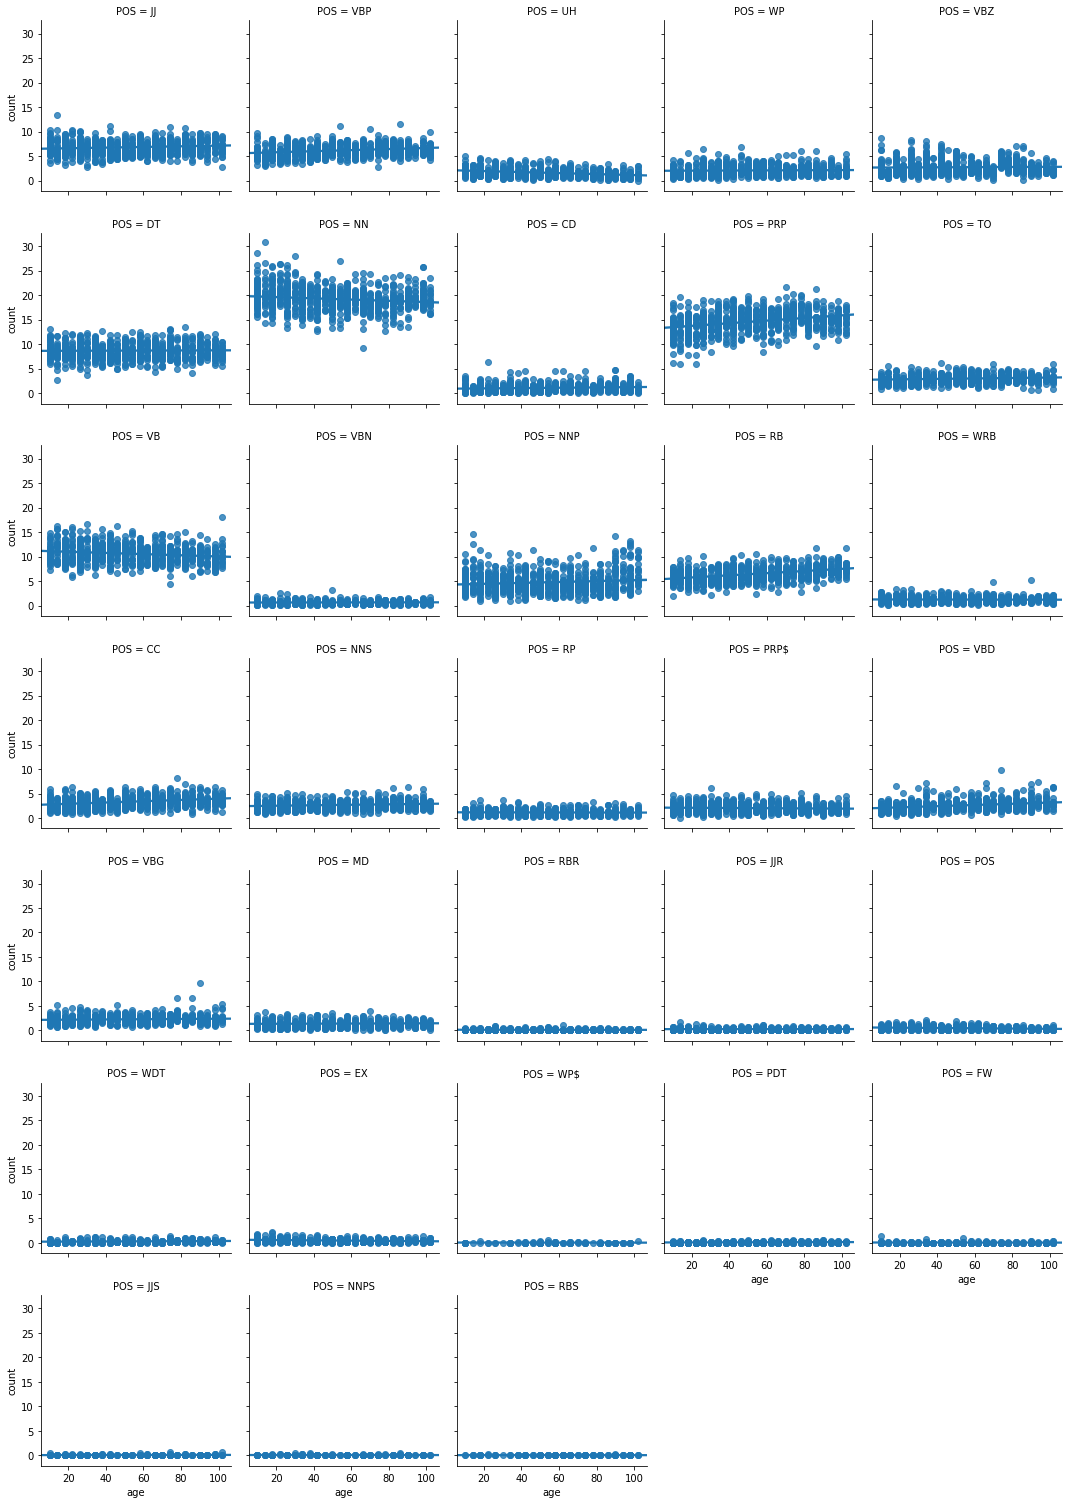

In [65]:
g = sns.FacetGrid(sessioncountsdf, col = 'POS', col_wrap=5)
g.map(sns.regplot, "age", "count")
#plt.savefig('pchatposdist.png',bbox_inches = 'tight')

#### For Books

In [54]:
bookdf['avg150wordPOScount'] = bookdf['tokens'].apply(lambda x:avgwordsample(x, 150, 50))

In [68]:
bookcountsdf = pd.DataFrame()
for i, r in bookdf.iterrows():
    bookPOSdf = pd.DataFrame.from_dict(r['avg150wordPOScount'], orient = 'index')
    bookPOSdf.reset_index(inplace=True)
    bookcountsdf = bookPOSdf.append(bookcountsdf)
    bookcountsdf.reset_index(inplace =True, drop=True)

bookcountsdf = bookcountsdf.rename(columns = {'index':'POS', 0:'count'})

In [69]:
bookcountsdf['age'] = 62 # for plotting purposes
bookcountsdf['source'] = 'Book'

In [70]:
# for every book, a POS count for its average 150 word count
bookcountsdf.head()

,POS,count,age,source
0,DT,16.24,62,Book
1,NN,23.82,62,Book
2,NNS,16.40,62,Book
3,NNP,7.28,62,Book
4,JJ,8.78,62,Book


Creates a DataFrame and plot combining the distribution of average 150 word POS counts for chat and books

In [71]:
booksessioncountsdf = sessioncountsdf.append(bookcountsdf)
booksessioncountsdf.reset_index(inplace=True, drop=True)
booksessioncountsdf = booksessioncountsdf[~booksessioncountsdf['POS'].isin(['SYM','LS','IN'])]

In [73]:
booksessioncountsdf.head()

,POS,count,age,source
0,JJ,6.04,10,highSES
1,VBP,6.54,10,highSES
2,UH,4.28,10,highSES
3,WP,1.70,10,highSES
4,VBZ,2.76,10,highSES


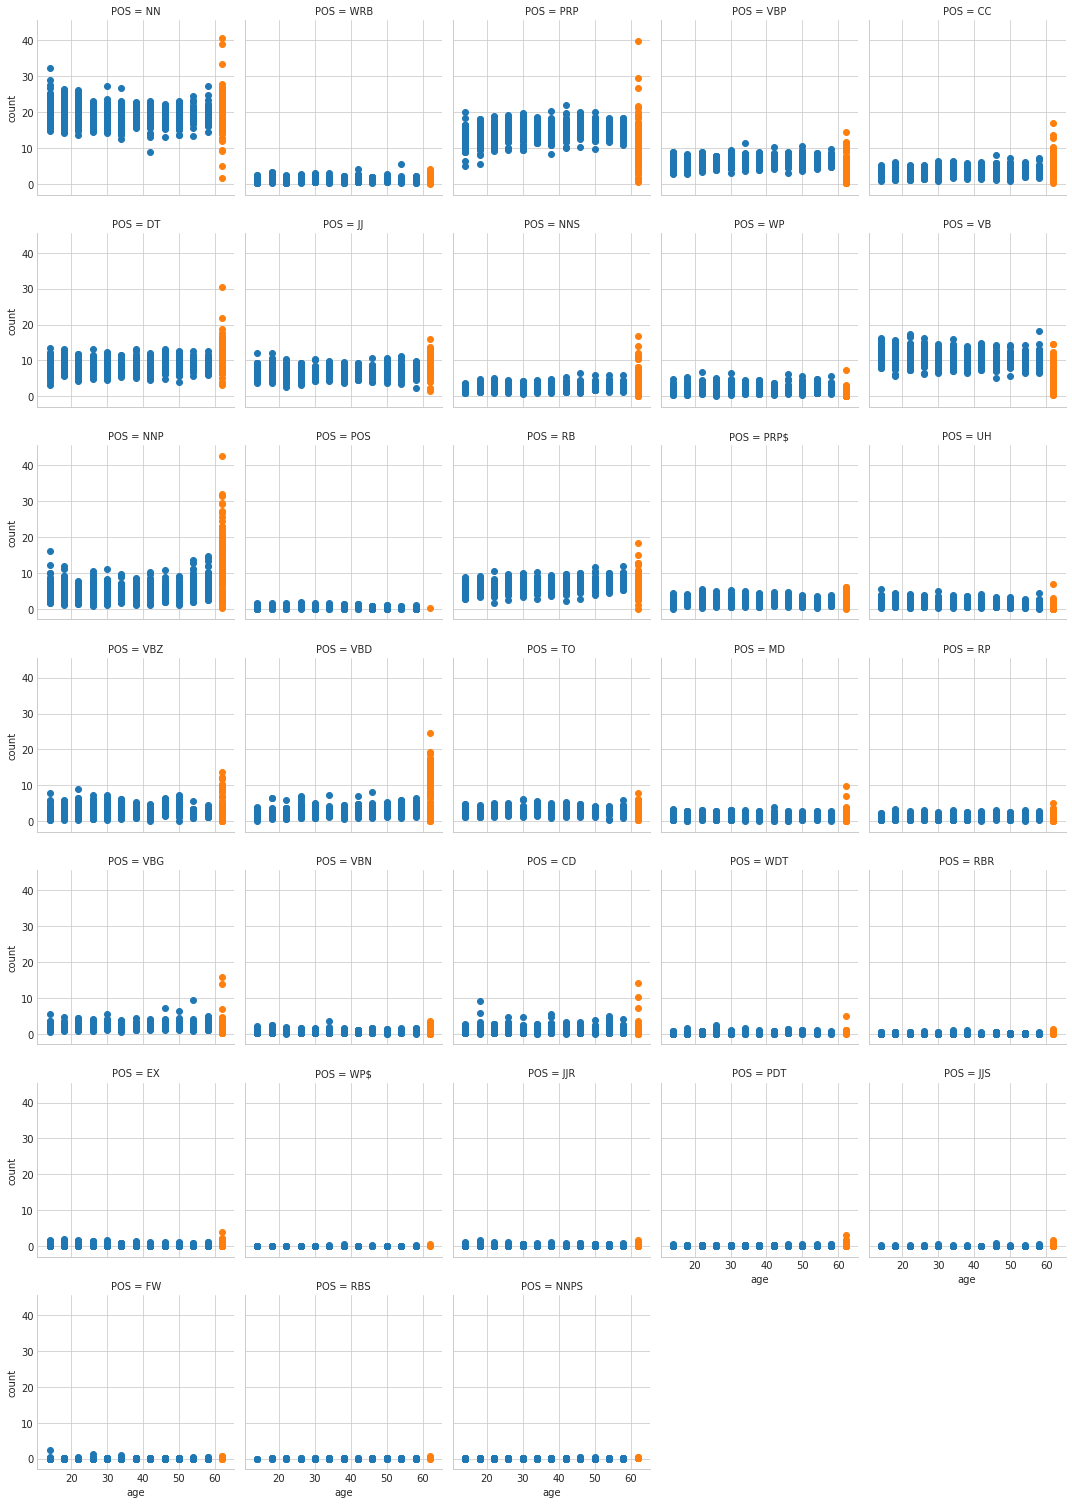

In [103]:
g = sns.FacetGrid(booksessioncountsdf, col = 'POS', hue='book', col_wrap=5)
g.map(plt.scatter, "age", "count")
#plt.savefig('p&bposdist.png',bbox_inches = 'tight')

Creates DataFrame and plots POS count distributions for 150 word samples from each book

In [74]:
bookcountsdf = pd.DataFrame()
for i, r in bookdf.iterrows():
    bookPOSdf = pd.DataFrame.from_dict(r['avg150wordPOScount'], orient = 'index')
    bookPOSdf.reset_index(inplace=True)
    bookcountsdf = bookPOSdf.append(bookcountsdf)
    bookcountsdf.reset_index(inplace =True, drop=True)

bookcountsdf = bookcountsdf.rename(columns = {'index':'POS', 0:'count'})

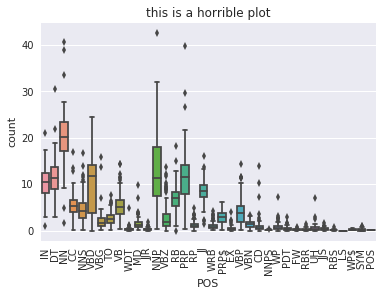

In [125]:
g = sns.boxplot(x = 'POS', y='count', data=bookcountsdf)
#axes = g.axes.flatten()
g.set_xticklabels(g.get_xticklabels(), rotation=90);
g.set_title('this is a horrible plot');

Creates DataFrame and plots with the average POS counts for 150 word samples by each session (and includes average book count).

In [79]:
sessionPOSdicts.head()

,age,lowSES,avg150wordPOScount,avgPOS
0,1,False,"[{'JJ': 6.040000000000001, 'VBP': 6.5400000000...","{'JJ': 6.9271698113207565, 'VBP': 5.7637735849..."
1,1,True,"[{'MD': 2.080000000000001, 'VB': 15.5599999999...","{'MD': 1.1508333333333336, 'VB': 11.9458333333..."
2,2,False,"[{'DT': 7.579999999999997, 'NN': 15.3200000000...","{'DT': 8.658214285714282, 'NN': 19.68178571428..."
3,2,True,"[{'NNP': 6.600000000000001, 'DT': 9.32, 'PRP':...","{'NNP': 5.180833333333335, 'DT': 8.44249999999..."
4,3,False,"[{'JJ': 4.100000000000001, 'NNP': 4.1000000000...","{'JJ': 6.6213559322033895, 'NNP': 4.1538983050..."


In [80]:
sessionavgcountsdf = pd.DataFrame()
for i, r in sessionPOSdicts.iterrows():
    sessiondf = pd.DataFrame.from_dict(r['avgPOS'], orient = 'index')
    sessiondf.reset_index(inplace=True)
    sessiondf['age'] = 4*i + 10
    if r['lowSES']:
        sessiondf['source'] = 'lowSES'
    else:
        sessiondf['source'] = 'highSES'
    sessionavgcountsdf = sessionavgcountsdf.append(sessiondf)
    sessionavgcountsdf.reset_index(inplace =True, drop=True)

sessionavgcountsdf = sessionavgcountsdf.rename(columns = {'index':'POS', 0:'count'})

In [81]:
sessionavgcountsdf.head()

,POS,count,age,source
0,JJ,6.927170,10,highSES
1,VBP,5.763774,10,highSES
2,UH,2.278491,10,highSES
3,IN,7.162642,10,highSES
4,WP,1.817358,10,highSES


In [82]:
bookavgPOSdicts = []
for i in range(100): #takes a few minutes
    if i % 10 == 0:
        print (i)
    dikt = averageSampleCounts(bookdf, n)
    bookavgPOSdicts.append(dikt)

0
10
20
30
40
50
60
70
80
90


In [84]:
bookavgavgPOSdict = getavgPOSdict(bookavgPOSdicts)

In [93]:
bookavgavgPOSdf = pd.DataFrame.from_dict(bookavgavgPOSdict, orient = 'index')
bookavgavgPOSdf.reset_index(inplace=True)
bookavgavgPOSdf['age'] = 62 #stipulate books as their own age for plotting purposes
bookavgavgPOSdf['source'] ='Book'
bookavgavgPOSdf = bookavgavgPOSdf.rename(columns = {'index':'POS', 0:'count'})
booksessionavgcountsdf = sessionavgcountsdf.append(bookavgavgPOSdf)
booksessionavgcountsdf = booksessionavgcountsdf[~booksessionavgcountsdf['POS'].isin(['SYM',"IN","LS"])]
booksessionavgcountsdf.reset_index(inplace=True,drop=True)


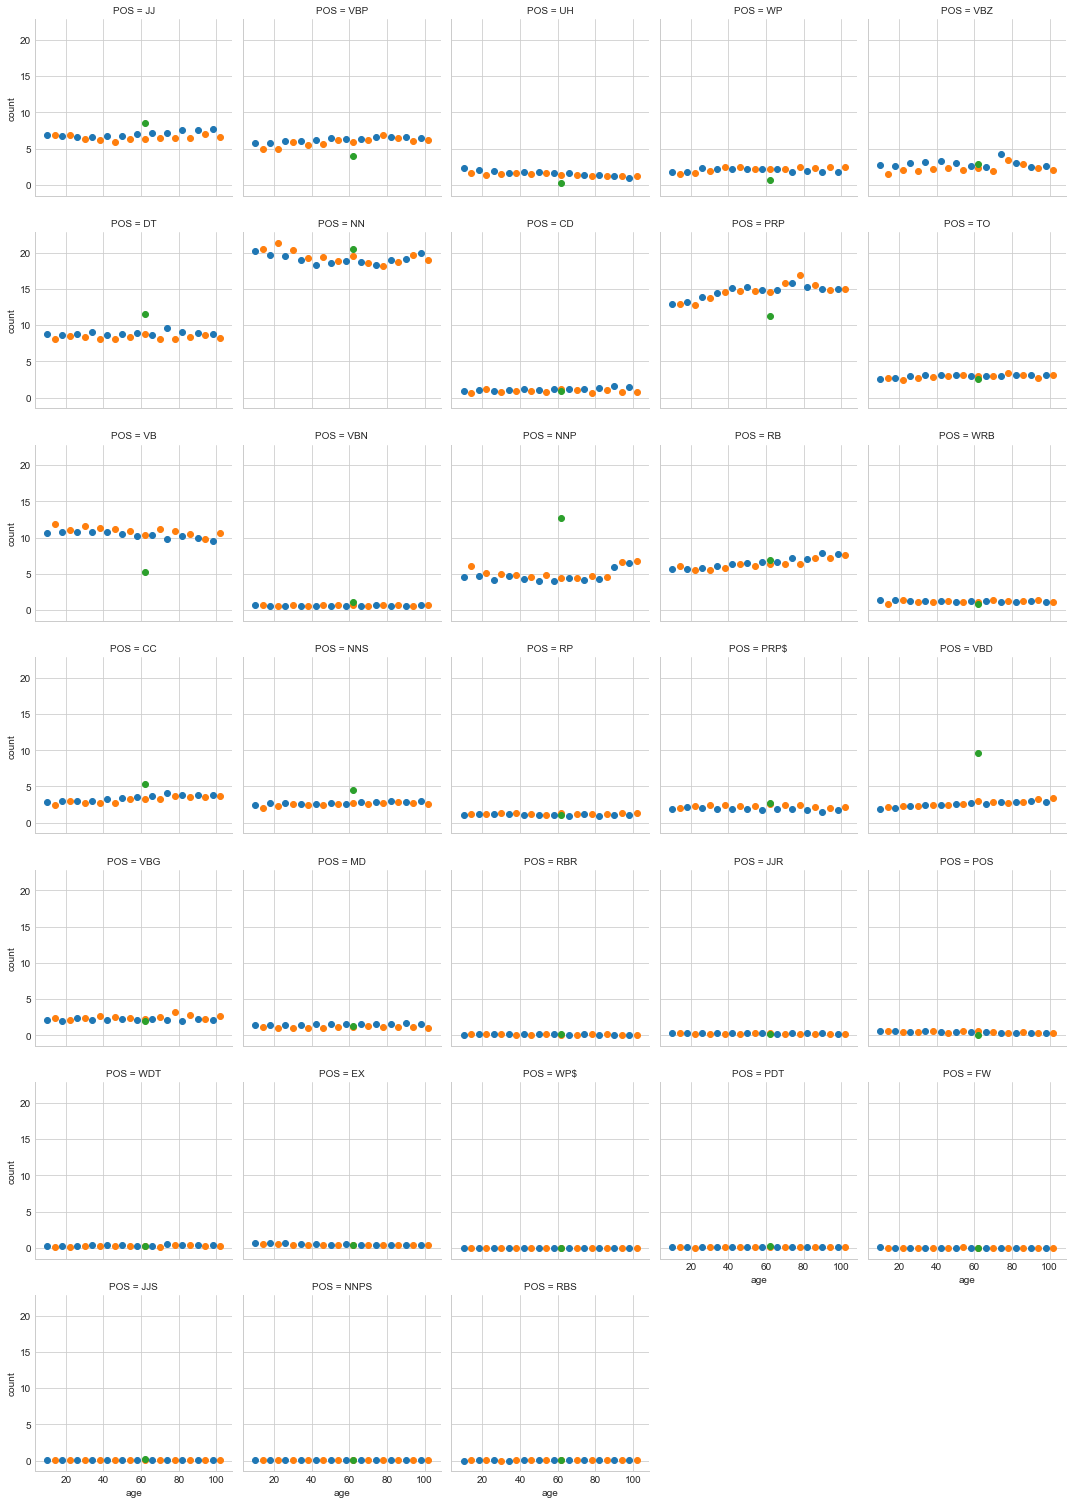

In [91]:
sns.set_style('whitegrid')
g = sns.FacetGrid(booksessionavgcountsdf, col = 'POS', hue='source', col_wrap=5)
g = g.map(plt.scatter, 'age', 'count')
#plt.savefig('p&bavgpos.png',bbox_inches = 'tight')

The following DataFrame and plot shows the average POS counts for word samples from both corpora (collapsing chat data across time.)

In [95]:
p_chats

,subject,age,p_chat,sents,sent_tokens,tokens,word_count,income,lowSES,avg150wordPOScount
0,22,1,"play with Mommy's hand . no . no, no, no . nop...","[play with Mommy's hand ., no ., no, no, no .,...","[[play, with, Mommy, ', s, hand, .], [no, .], ...","[play, with, Mommy, ', s, hand, ., no, ., no, ...",4702,5,False,"{'JJ': 6.040000000000001, 'VBP': 6.54000000000..."
1,22,2,what are you crawling for ? stand up . what ...,"[ what are you crawling for ?, stand up ., wh...","[[what, are, you, crawling, for, ?], [stand, u...","[what, are, you, crawling, for, ?, stand, up, ...",5798,5,False,"{'DT': 7.579999999999997, 'NN': 15.32000000000..."
2,22,3,you want to show her how you do a head+stand ?...,[you want to show her how you do a head+stand ...,"[[you, want, to, show, her, how, you, do, a, h...","[you, want, to, show, her, how, you, do, a, he...",5477,5,False,"{'JJ': 4.100000000000001, 'NNP': 4.10000000000..."
3,22,4,how do flowers taste ? yeah . do you eat flow...,"[how do flowers taste ?, yeah ., do you eat fl...","[[how, do, flowers, taste, ?], [yeah, .], [do,...","[how, do, flowers, taste, ?, yeah, ., do, you,...",8349,5,False,"{'PRP': 18.180000000000003, 'VB': 10.379999999..."
4,22,5,what ? you brought it down because you said...,"[ what ?, you brought it down because you said...","[[what, ?], [you, brought, it, down, because, ...","[what, ?, you, brought, it, down, because, you...",6904,5,False,"{'NN': 18.880000000000006, 'JJ': 6.52, 'IN': 8..."
5,22,6,do do do . &xxx get the foot book ? where is ...,"[ do do do ., &xxx get the foot book ?, where ...","[[do, do, do, .], [&, xxx, get, the, foot, boo...","[do, do, do, ., &, xxx, get, the, foot, book, ...",7141,5,False,"{'PRP': 13.74, 'VBP': 6.979999999999998, 'JJ':..."
6,22,7,right ? are you a mysterious girl ? no on...,"[ right ?, are you a mysterious girl ?, no on...","[[right, ?], [are, you, a, mysterious, girl, ?...","[right, ?, are, you, a, mysterious, girl, ?, n...",5125,5,False,"{'NN': 18.46, 'WRB': 1.2000000000000004, 'PRP'..."
7,22,8,"no, I'm not going all the way up . who's the...","[ no, I'm not going all the way up ., who's th...","[[no, ,, I, ', m, not, going, all, the, way, u...","[no, ,, I, ', m, not, going, all, the, way, up...",5432,5,False,"{'WDT': 0.38000000000000006, 'VBP': 6.14, 'DT'..."
8,22,9,it is a bride's veil . can we get married ? b...,"[it is a bride's veil ., can we get married ?,...","[[it, is, a, bride, ', s, veil, .], [can, we, ...","[it, is, a, bride, ', s, veil, ., can, we, get...",7067,5,False,"{'NNS': 3.7200000000000015, 'NN': 16.680000000..."
9,22,10,what are you guys doing ? you guys want...,"[ what are you guys doing ?, you guys want...","[[what, are, you, guys, doing, ?], [you, guys,...","[what, are, you, guys, doing, ?, you, guys, wa...",6034,5,False,"{'NNS': 3.060000000000002, 'RB': 7.41999999999..."


In [104]:
lowSESp_chats = p_chats[p_chats.lowSES]
lowSESp_chats.reset_index(inplace=True, drop=True)

In [105]:
highSESp_chats = p_chats[~p_chats.lowSES]
highSESp_chats.reset_index(inplace=True, drop=True)

In [106]:
highSESchatavgPOSdicts = []
for i in range(100): #slow (several minutes)
    if i % 10 == 0:
        print(i)
    dikt = averageSampleCounts(highSESp_chats, n)
    highSESchatavgPOSdicts.append(dikt)

highSESchatavgavgPOSdict = getavgPOSdict(highSESchatavgPOSdicts)

0


/Users/josephdenby/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/josephdenby/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/josephdenby/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

10
20
30
40
50
60
70
80
90


In [108]:
lowSESchatavgPOSdicts = []
for i in range(100): #slow (several minutes)
    if i % 10 == 0:
        print(i)
    dikt = averageSampleCounts(lowSESp_chats, n)
    lowSESchatavgPOSdicts.append(dikt)

lowSESchatavgavgPOSdict = getavgPOSdict(lowSESchatavgPOSdicts)

0


/Users/josephdenby/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/josephdenby/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/josephdenby/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

10
20
30
40
50
60
70
80
90


In [128]:
chatavgPOSdicts = []
for i in range(100): #slow (several minutes)
    if i % 10 == 0:
        print(i)
    dikt = averageSampleCounts(p_chats, n)
    chatavgPOSdicts.append(dikt)

chatavgavgPOSdict = getavgPOSdict(chatavgPOSdicts)

0
10
20
30
40
50
60
70
80
90


In [ ]:
chatavgPOSdf = pd.DataFrame.from_dict(chatavgavgPOSdict, orient = 'index')
    bookavgPOSdf = pd.DataFrame.from_dict(bookavgavgPOSdict, orient = 'index')
    
    chatavgPOSdf = chatavgPOSdf.reset_index()
    bookavgPOSdf = bookavgPOSdf.reset_index()
    
    chatavgPOSdf = chatavgPOSdf.rename(columns = {'index': 'POS', 0: 'chat'})
    bookavgPOSdf = bookavgPOSdf.rename(columns = {'index': 'POS', 0: 'book'})
    
    compareavgPOSdf = bookavgPOSdf.merge(chatavgPOSdf, how='left', on='POS',)
    compareavgPOSdf['abs_diff'] = compareavgPOSdf.apply(lambda x: x['book'] - x['chat'], axis=1)
    compareavgPOSdf['factor_diff'] = compareavgPOSdf.apply(lambda x: (x['book']-x['chat'])/x['book'], axis=1)
    compareavgPOSdf = compareavgPOSdf.sort_values('factor_diff', ascending=False)
    compareavgPOSdf = compareavgPOSdf.reset_index(drop=True)
    compareavgPOSdf = compareavgPOSdf.melt(id_vars=['POS'], value_vars=['book', 'chat'], var_name='source', value_name='avgcount')
    
    return compareavgPOSdf

In [113]:
lowdf = pd.DataFrame.from_dict(lowSESchatavgavgPOSdict, orient = 'index')
highdf = pd.DataFrame.from_dict(highSESchatavgavgPOSdict, orient = 'index')
lowdf = lowdf.reset_index()
highdf = highdf.reset_index()
lowdf = lowdf.rename(columns = {'index': 'POS', 0: 'lowSES'})
highdf = highdf.rename(columns = {'index': 'POS', 0: 'highSES'})

compareavgPOSdf = lowdf.merge(highdf, how='left', on='POS',)
compareavgPOSdf['abs_diff'] = compareavgPOSdf.apply(lambda x: x['highSES'] - x['lowSES'], axis=1)
compareavgPOSdf['factor_diff'] = compareavgPOSdf.apply(lambda x: (x['highSES']-x['lowSES'])/x['highSES'], axis=1)
compareavgPOSdf = compareavgPOSdf.sort_values('factor_diff', ascending=False)
compareavgPOSdf = compareavgPOSdf.reset_index(drop=True)
compareavgPOSdf = compareavgPOSdf.melt(id_vars=['POS'], value_vars=['highSES', 'lowSES'], var_name='source', value_name='avgcount')

In [115]:
compareavgPOSdf.head()

,POS,source,avgcount
0,WDT,highSES,0.335465
1,JJS,highSES,0.031680
2,CD,highSES,1.141077
3,MD,highSES,1.513719
4,VBZ,highSES,2.953393


In [121]:
bookPOSdf = pd.DataFrame.from_dict(bookavgavgPOSdict, orient = 'index')
bookPOSdf.reset_index(inplace=True)
bookPOSdf = bookPOSdf.rename(columns = {'index': 'POS', 0: 'avgcount'})
bookPOSdf['source'] = 'Book'


In [124]:
trialPOSdf = compareavgPOSdf.append(bookPOSdf)
trialPOSdf.reset_index(inplace=True, drop=True)

In [109]:
bookavgavgPOSdict = getavgPOSdict(bookavgPOSdicts)

In [135]:
compareavgPOSdf = getPOSdf(chatavgavgPOSdict, bookavgavgPOSdict)
compareavgPOSdf = compareavgPOSdf[~compareavgPOSdf['POS'].isin(['SYM','IN','FW','VBG', 'WP'])]
compareavgPOSdf = compareavgPOSdf[compareavgPOSdf['avgcount']>2]

In [136]:
compareavgPOSdf.head()

,POS,source,avgcount
3,VBD,book,9.629082
4,NNP,book,12.757041
8,NNS,book,4.478571
9,CC,book,5.343367
11,DT,book,11.505204


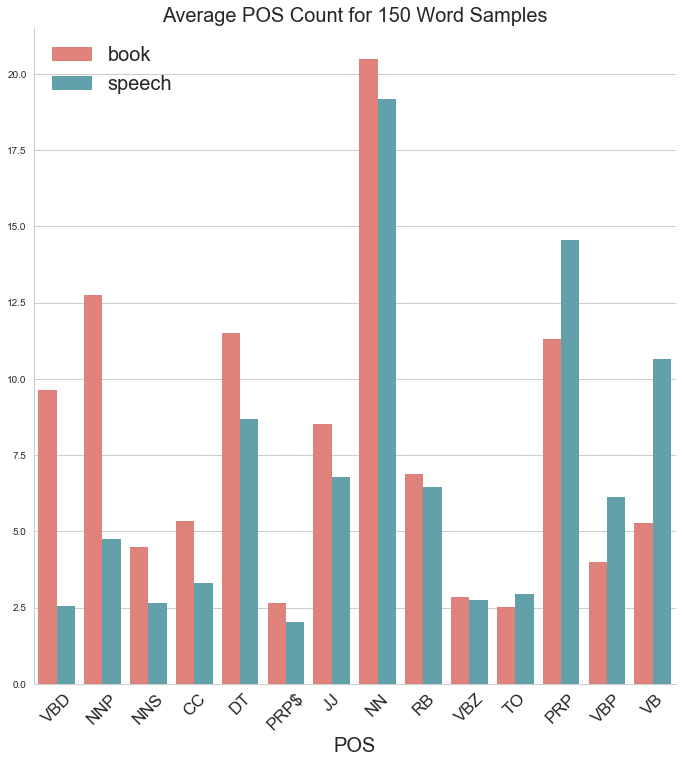

In [152]:
sns.set(font_scale=1.2, style='whitegrid')

sns.set_style('whitegrid')

g = sns.factorplot(x = 'POS', y = 'avgcount', hue='source', data=compareavgPOSdf, size=10, kind='bar', palette={'book':'#EF746C' ,'speech':'#56AAB6'}, legend=False)
plt.ylabel('')
g.set_yticklabels(size=10)
g.set_xticklabels(rotation=45, size=17)
plt.legend(loc=2, prop={'size':20})
axes = g.axes.flatten()
axes[0].set_title('Average POS Count for ' + str(n) + ' Word Samples', fontsize=20);
g.set_xlabels("POS",fontsize=20);
g.savefig('avgPOS150.png', dpi=200 ,bbox_inches = 'tight')


`NNP` = Proper Noun; `VBP` = Verb 'to be', singular present non 3rd (e.g, 'am', 'are'); `DT` = Determiner (e.g., 'a', 'the', 'every'); `VBD` = Verb 'to be', past tense; `IN`= preposition, subordinating conjunction; `CC` = coordination conjunction (e.g., 'and'); `PRP` = Personal Pronoun (e.g., 'I', 'she', 'you', 'it'); `VB` = verb 'to be', base form (i.e., 'be'); `NNS` = plural nouns; `WP` = verb, sing. present non 3rd (e.g., 'take', 'play')

### EVERYTHING BELOW IS PURELY EDA AND PROBABLY DONE WRONG – NOT MUCH TO REPORT

Compute stopword list based on corpus frequency and create tokenized and normalized nltk sentence columns.

In [5]:
alltokens = bookdf['tokens'].sum()

#all words sorted by frequency
allcountedWords = wordCounter(alltokens)
allcountedWords.sort_values('count', ascending=False, inplace=True)

stop_words_freq = []
countsDict = {}
for word in alltokens:
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:100]
for word, count in word_counts:
    if word == 'little':
        break
    else:
        stop_words_freq.append(word)

In [7]:
bookdf['tokenized_sents'] = bookdf['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
bookdf['normalized_sents'] = bookdf['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = stop_words_freq, stemmer = None) for s in x])
bookdf[:5]

,author,text,title,tokens,nltktext,tokenized_sents,normalized_sents
0,Jules Feiffer,"George’s mother said: ""Bark, George."" George w...","Bark, George","[George, ’, s, mother, said, :, ``, Bark, ,, G...","(George, ’, s, mother, said, :, ``, Bark, ,, G...","[[George, ’, s, mother, said, :, ``, Bark, ,, ...","[[george, mother, bark, george], [george, went..."
1,Robert McCloskey,"One day, Little Sal went with her mother to Bl...",Blueberries for Sal,"[One, day, ,, Little, Sal, went, with, her, mo...","(One, day, ,, Little, Sal, went, with, her, mo...","[[One, day, ,, Little, Sal, went, with, her, m...","[[one, day, little, sal, went, mother, blueber..."
2,Bill Martin Jr,"Brown Bear, Brown Bear, What do you see? I see...","Brown Bear, Brown Bear, What Do You See?","[Brown, Bear, ,, Brown, Bear, ,, What, do, you...","(Brown, Bear, ,, Brown, Bear, ,, What, do, you...","[[Brown, Bear, ,, Brown, Bear, ,, What, do, yo...","[[brown, bear, brown, bear, what, do, see], [i..."
3,Doreen Cronin,Farmer Brown has a problem. His cows like to t...,"Click, Clack, Moo Cows that Type","[Farmer, Brown, has, a, problem, ., His, cows,...","(Farmer, Brown, has, a, problem, ., His, cows,...","[[Farmer, Brown, has, a, problem, .], [His, co...","[[farmer, brown, has, problem], [cows, type], ..."
4,Judi Barrett,We were all sitting around the big kitchen tab...,Cloudy With a Chance of Meatballs,"[We, were, all, sitting, around, the, big, kit...","(We, were, all, sitting, around, the, big, kit...","[[We, were, all, sitting, around, the, big, ki...","[[we, were, sitting, around, big, kitchen, tab..."


Now, create a tf-idf matrix. This is a sparse matrix with each row being a document (book) and each column a word appearing in the corpus.

First, a vectorizer that creates a count matrix (each field is the number of times a word appears in a document).

In [117]:
#First it needs to be initialized
bookCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
bookgroupVects = bookCountVectorizer.fit_transform(bookdf['text'])

In [16]:
bookgroupVects.shape

(100, 5577)

In [49]:
bookCountVectorizer.vocabulary_.get("")

Now, compute the tf-idf matrix. This assigns a score (tf-idf) to each word in each document according to its 'tellingness.' Each score is an indication of the word's importance within a document weighted by its relative presence across the entire corpus.

In [57]:

#initialize
bookTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stop_words_freq, norm='l2')
#train
bookgroupTFVects = bookTFVectorizer.fit_transform(bookdf['text'])

In [62]:
list(zip(bookTFVectorizer.vocabulary_.keys(), bookgroupTFVects.data))[:20]

[('george', 0.8250452029628907),
 ('mother', 0.0806859374239559),
 ('bark', 0.30346153103359197),
 ('went', 0.10025854047243683),
 ('meow', 0.07409044053577216),
 ('no', 0.02782304744964275),
 ('cats', 0.023572720084654025),
 ('go', 0.053296564657065615),
 ('dogs', 0.06539709675813102),
 ('arf', 0.12138461241343679),
 ('now', 0.02875583332681148),
 ('quack', 0.1481808810715443),
 ('ducks', 0.02607259267803477),
 ('oink', 0.07821777803410432),
 ('pigs', 0.02607259267803477),
 ('moo', 0.055692561019956906),
 ('took', 0.013447656237325984),
 ('vet', 0.2124230717235144),
 ('ll', 0.011014437746450794),
 ('soon', 0.014532100367612747)]

In [123]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 4).fit(bookgroupTFVects.toarray())
reduced_data = pca.transform(bookgroupTFVects.toarray())
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
booktitles = bookdf['title']
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

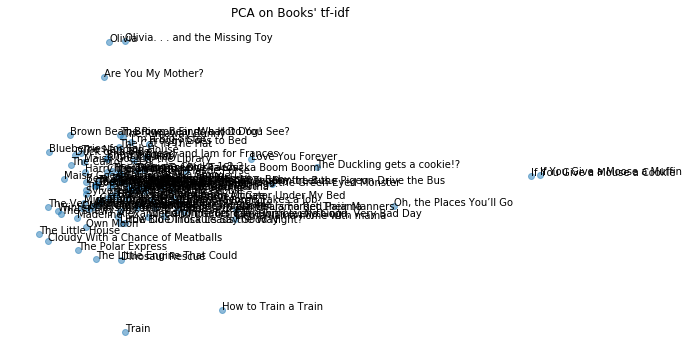

In [127]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 2], reduced_data[:, 3], alpha = 0.5)
for i, booktitle in enumerate(booktitles):
    ax.annotate(booktitle, (reduced_data[i,2], reduced_data[i,3]))
plt.xticks(())
plt.yticks(())
plt.title('PCA on Books\' tf-idf')
plt.show()

Based on above filtering, most books have similar tf-idf vectors except for a few. Upon closer inspection, these books appear to use idiosyncratic words frequently (e.g., George, Llama). I can try adding these to the stop words list to see how this changes the PCA.

In [96]:
new_stop_words = stop_words_freq[:] + ['george', 'llama']
#initialize
newbookTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=.5, min_df=3, stop_words=new_stop_words, norm='l2')
#train
newbookgroupTFVects = newbookTFVectorizer.fit_transform(bookdf['text'])

In general – can tweak a few parameters w.r.t. tfidfvectorizer: max_df, min_df, stop_words.
Could also experiment with different stemming / lemmatization pre-processing.

In [129]:
newpca = PCA(n_components = 10).fit(newbookgroupTFVects.toarray())
newreduced_data = newpca.transform(newbookgroupTFVects.toarray())
components = newpca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
booktitles = bookdf['title']
#words = [terms[i] for i in keyword_ids]#Turn the ids into words.
#x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
#y = components[:,keyword_ids][1,:]

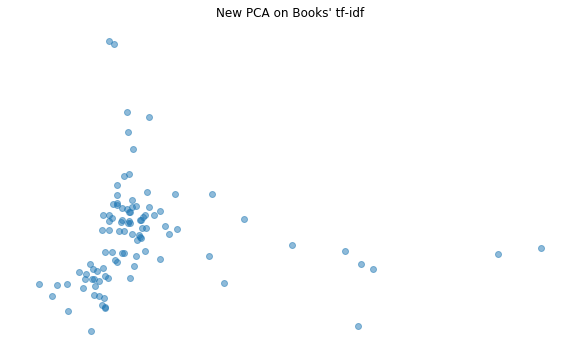

In [103]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(newreduced_data[:, 0], newreduced_data[:, 1], alpha = 0.5)
#for i, booktitle in enumerate(booktitles):
 #   ax.annotate(booktitle, (newreduced_data[i,0], newreduced_data[i,1]))
plt.xticks(())
plt.yticks(())
plt.title('New PCA on Books\' tf-idf')
plt.show()

Clustering algorithm:

In [111]:
numCategories = 3

In [112]:
bookKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
bookKM.fit(newbookgroupTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

This allows us to visualize the top 10 words per cluster:

In [128]:
terms = bookTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = bookKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 any
 eve
 along
 babushka
 become
 already
 across
 arrangement
 battered
 dearest


Cluster 1:
 elves
 due
 bumps
 claimed
 backward
 enters
 businesses
 dragon
 approached
 examine


Cluster 2:
 chopping
 choking
 ceilings
 charlie
 battered
 bumps
 bathtub
 counter
 expecting
 chops




Here we can reduce the tf-idf matrix using PCA in order to make visualization easier.

In [114]:
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in bookKM.labels_]

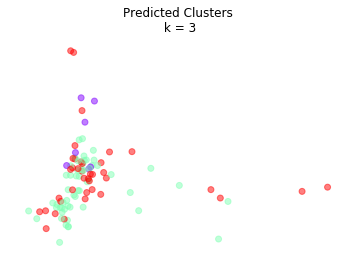

In [115]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(newreduced_data[:, 0], newreduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()